# Homework03:  Topic Modeling with Latent Semantic Analysis

Latent Semantic Analysis (LSA) is a method for finding latent similarities between documents treated as a bag of words by using a low rank approximation. It is used for document classification, clustering and retrieval. For example, LSA can be used to search for prior art given a new patent application. In this homework, we will implement a small library for simple latent semantic analysis as a practical example of the application of SVD. The ideas are very similar to PCA. SVD is also used in recommender systems in an similar fashion (for an SVD-based recommender system library, see [Surpise](http://surpriselib.com). 

We will implement a toy example of LSA to get familiar with the ideas. If you want to use LSA or similar methods for statistical language analysis, the most efficient Python libraries are probably [gensim](https://radimrehurek.com/gensim/) and [spaCy](https://spacy.io) - these also provide an online algorithm - i.e. the training information can be continuously updated. Other useful functions for processing natural language can be found in the [Natural Language Toolkit](http://www.nltk.org/).

**Note**: The SVD from scipy.linalg performs a full decomposition, which is inefficient since we only need to decompose until we get the first k singluar values. If the SVD from `scipy.linalg` is too slow, please use the `sparsesvd` function from the [sparsesvd](https://pypi.python.org/pypi/sparsesvd/) package to perform SVD instead.  You can install in the usual way with 
```
!pip install sparsesvd
```

Then import the following
```python
from sparsesvd import sparsesvd 
from scipy.sparse import csc_matrix 
```

and use as follows
```python
sparsesvd(csc_matrix(M), k=10)
```

**Exercise 1 (20 points)**.  Calculating pairwise distance matrices.

Suppose we want to construct a distance matrix between the rows of a matrix. For example, given the matrix 

```python
M = np.array([[1,2,3],[4,5,6]])
```

the distance matrix using Euclidean distance as the measure would be
```python
[[ 0.000  1.414  2.828]
 [ 1.414  0.000  1.414]
 [ 2.828  1.414  0.000]] 
```
if $M$ was a collection of column vectors.

Write a function to calculate the pairwise-distance matrix given the matrix $M$ and some arbitrary distance function. Your functions should have the following signature:
```
def func_name(M, distance_func):
    pass
```

0. Write a distance function for the Euclidean, squared Euclidean and cosine measures.
1. Write the function using looping for M as a collection of row vectors.
2. Write the function using looping for M as a collection of column vectors.
3. Wrtie the function using broadcasting for M as a collection of row vectors.
4. Write the function using broadcasting for M as a collection of column vectors. 

For 3 and 4, try to avoid using transposition (but if you get stuck, there will be no penalty for using transposition). Check that all four functions give the same result when applied to the given matrix $M$.

In [16]:
import scipy.linalg as la
import numpy as np

In [114]:
from scipy.spatial import distance_matrix

In [129]:
def distance_euclidiean(x, y):
    """calc euc distance: sqrt sum of the difference between 2 vectors"""
    return np.sqrt(np.sum((x-y)**2))


In [130]:
def distance_euclidieanSquared(x, y):
    """calc euc squared distance: sum of the difference between 2 vectors"""
    return np.sum((x-y)**2)

In [137]:
def distance_cosine(x, y):
    """calc cosine distance: 1 - uv/|u||v|"""
    return 1 - x @ y / la.norm(x) / la.norm(y)

In [128]:
x=np.array([1,4])
y=np.array([2,5])
np.sqrt(np.sum((x-y)**2))

1.4142135623730951

In [161]:
M = np.array([[1,2,3],[4,5,6]])
M.shape
M[:,1]

array([2, 5])

# loops

In [158]:
def dist_row_loop(M, distance_func):
    """calculating distance matrix trying m as row vectors"""
    rows = M.shape[0]
    table = np.zeros((rows, rows), dtype='float')
    for i in range(rows):
        for j in range(rows):
            table[i, j] = distance_func(M[i, :], M[j, :])   
    return table
dist_row_loop(M, distance_func=distance_euclidiean)

array([[0.        , 5.19615242],
       [5.19615242, 0.        ]])

In [162]:
def dist_col_loop(M, distance_func):
    """calculating distance matrix trying m as col vectors"""
    cols = M.shape[1]
    table = np.zeros((cols, cols), dtype='float')
    for i in range(cols):
        for j in range(cols):
            table[i, j] = distance_func(M[:, i], M[:, j])   
    return table
dist_col_loop(M, distance_func=distance_euclidiean)

array([[0.        , 1.41421356, 2.82842712],
       [1.41421356, 0.        , 1.41421356],
       [2.82842712, 1.41421356, 0.        ]])

In [164]:
M

array([[1, 2, 3],
       [4, 5, 6]])

In [170]:
np.sqrt(np.sum((x[:, np.newaxis] - y[np.newaxis])**2, axis=2))

7.3484692283495345

# broadcasting

In [172]:
def dist_row_broadcast(M, distance_func):
    """calculating distance matrix trying m as row vectors"""
    if distance_func=="distance_euclidiean":
        table = np.sqrt(np.sum((M[:, np.newaxis] - M[np.newaxis])**2, axis=2))
    elif distance_func=="distance_euclidieanSquared":
        table = np.sum((M[:, np.newaxis] - M[np.newaxis])**2, axis=2)
    elif distance_func=="distance_cosine": 
        table = 1
    return table
dist_row_broadcast(M, distance_func="distance_euclidiean")

array([[0.        , 5.19615242],
       [5.19615242, 0.        ]])

In [174]:
def dist_col_broadcast(M, distance_func):
    """calculating distance matrix trying m as row vectors"""
    if distance_func=="distance_euclidiean":
        table = np.sqrt(np.sum((M[np.newaxis, :] - M[np.newaxis])**2, axis=2))
    elif distance_func=="distance_euclidieanSquared":
        table = np.sum((M[np.newaxis, :] - M[np.newaxis])**2, axis=2)
    elif distance_func=="distance_cosine": 
        table = 1
    return table
dist_col_broadcast(M, distance_func="distance_euclidiean")

array([[0., 0., 0.]])

**Exercise 2 (20 points)**. 

**Exercise 2 (20 points)**. Write 3 functions to calculate the term frequency (tf), the inverse document frequency (idf) and the product (tf-idf). Each function should take a single argument `docs`, which is a dictionary of (key=identifier, value=document text) pairs, and return an appropriately sized array. Convert '-' to ' ' (space), remove punctuation, convert text to lowercase and split on whitespace to generate a collection of terms from the document text.

- tf = the number of occurrences of term $i$ in document $j$
- idf = $\log \frac{n}{1 + \text{df}_i}$ where $n$ is the total number of documents and $\text{df}_i$ is the number of documents in which term $i$ occurs.

Print the table of tf-idf values for the following document collection

```
s1 = "The quick brown fox"
s2 = "Brown fox jumps over the jumps jumps jumps"
s3 = "The the the lazy dog elephant."
s4 = "The the the the the dog peacock lion tiger elephant"

docs = {'s1': s1, 's2': s2, 's3': s3, 's4': s4}
```

In [70]:
import string
from collections import Counter
def processTxt(txt):
    return txt.lower().replace('-',' ').translate(str.maketrans("","",string.punctuation)).split(" ")

In [72]:
processTxt(s1)

['the', 'quick', 'brown', 'fox']

In [71]:
s1 = "The quick brown fox"
s2 = "Brown fox jumps over the jumps jumps jumps"
s3 = "The the the lazy dog elephant."
s4 = "The the the the the dog peacock lion tiger elephant"
docs = {'s1': s1, 's2': s2, 's3': s3, 's4': s4}

In [108]:
def tf(doc):
    """calc term freq"""
    sentLst = list(docs.values())
    doc_words = [processTxt(content) for content in sentLst]
    vocab = set([word for words in doc_words for word in words])
    table = np.zeros((len(vocab), len(sentLst)), dtype='int')
    for i, word in enumerate(vocab):
        for j, doc in enumerate(doc_words):
            table[i, j] = doc.count(word)
    return table #pd.DataFrame(table, index=vocab, columns=docs.keys())
tf(docs)

array([[0, 0, 0, 1],
       [1, 1, 0, 0],
       [0, 0, 1, 1],
       [1, 1, 3, 5],
       [1, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 4, 0, 0]])

In [109]:
def idf(docs):
    """calc inverse document freq"""
    sentLst = list(docs.values())
    doc_words = [processTxt(content) for content in sentLst]
    vocab = set([word for words in doc_words for word in words])
    table = np.zeros((len(vocab), 1), dtype='float')
    for i, word in enumerate(vocab):
        df = sum([word in doc for doc in doc_words])
        table[i] = np.log(len(sentLst)/(1 + df))
    return table #pd.DataFrame(table, index=vocab)
idf(docs)

array([[ 0.69314718],
       [ 0.28768207],
       [ 0.28768207],
       [-0.22314355],
       [ 0.28768207],
       [ 0.69314718],
       [ 0.28768207],
       [ 0.69314718],
       [ 0.69314718],
       [ 0.69314718],
       [ 0.69314718],
       [ 0.69314718]])

In [112]:
def tfidf(docs):
    """calc tf-idf"""
    return pd.DataFrame(tf(docs) * idf(docs), index=vocab, columns=docs.keys())

In [113]:
tfidf(docs)

,s1,s2,s3,s4
lion,0.000000,0.000000,0.000000,0.693147
fox,0.287682,0.287682,0.000000,0.000000
dog,0.000000,0.000000,0.287682,0.287682
the,-0.223144,-0.223144,-0.669431,-1.115718
brown,0.287682,0.287682,0.000000,0.000000
over,0.000000,0.693147,0.000000,0.000000
elephant,0.000000,0.000000,0.287682,0.287682
peacock,0.000000,0.000000,0.000000,0.693147
quick,0.693147,0.000000,0.000000,0.000000
tiger,0.000000,0.000000,0.000000,0.693147


**Exercise 3 (20 points)**. 

1. Write a function that takes a matrix $M$ and an integer $k$ as arguments, and reconstructs a reduced matrix using only the $k$ largest singular values. Use the `scipy.linagl.svd` function to perform the decomposition. This is the least squares approximation to the matrix $M$ in $k$ dimensions.

2. Apply the function you just wrote to the following term-frequency matrix for a set of $9$ documents using $k=2$ and print the reconstructed matrix $M'$.
```
M = np.array([[1, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 1, 0, 0, 0, 0],
       [0, 1, 1, 2, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1]])
```

3. Calculate the pairwise correlation matrix for the original matrix M and the reconstructed matrix using $k=2$ singular values (you may use [scipy.stats.spearmanr](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html) to do the calculations). Consider the fist 5 sets of documents as one group $G1$ and the last 4 as another group $G2$ (i.e. first 5 and last 4 columns). What is the average within group correlation for $G1$, $G2$ and the average cross-group correlation for G1-G2 using either $M$ or $M'$. (Do not include self-correlation in the within-group calculations.).

In [46]:
import numpy.linalg as la

def svdk(M, k):
    """perform full svd decomposition and then take first k features"""
    U, s, V = np.linalg.svd(M)
    reducedMatrix = U[:, :k] @ np.diag(s[:k]) @ V[:k, :]
    return reducedMatrix

In [47]:
M = np.array([[1, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 1, 0, 0, 0, 0],
       [0, 1, 1, 2, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1]])
reducedM = svdk(M, 2)
reducedM

array([[ 0.16205797,  0.40049828,  0.37895454,  0.46756626,  0.17595367,
        -0.05265495, -0.11514284, -0.15910198, -0.09183827],
       [ 0.14058529,  0.36980077,  0.32899603,  0.40042722,  0.16497247,
        -0.03281545, -0.07056857, -0.09676827, -0.04298073],
       [ 0.15244948,  0.50500444,  0.35793658,  0.41010678,  0.23623173,
         0.02421652,  0.05978051,  0.0868573 ,  0.12396632],
       [ 0.25804933,  0.84112343,  0.60571995,  0.69735717,  0.39231795,
         0.03311801,  0.08324491,  0.12177239,  0.18737973],
       [ 0.44878975,  1.23436483,  1.0508615 ,  1.26579559,  0.55633139,
        -0.07378998, -0.15469383, -0.20959816, -0.04887954],
       [ 0.15955428,  0.5816819 ,  0.37521897,  0.41689768,  0.27654052,
         0.05590374,  0.1322185 ,  0.18891146,  0.21690761],
       [ 0.15955428,  0.5816819 ,  0.37521897,  0.41689768,  0.27654052,
         0.05590374,  0.1322185 ,  0.18891146,  0.21690761],
       [ 0.21846278,  0.54958058,  0.51096047,  0.62805802,  0

In [51]:
G1 = M[:,:4]
G2 = M[:,4:]

Within group correlation

In [66]:
from scipy.stats import spearmanr
np.mean(spearmanr(G1))

0.40060518014819646

In [67]:
np.mean(spearmanr(G2))

0.2706084043264429

Cross group correlation

In [68]:
np.mean(spearmanr(G1, G2))

0.18691666316271546

In [69]:
np.mean(spearmanr(reducedM[:,:4], reducedM[:,4:]))

0.08479286680664984

**Exercise 4 (40 points)**. Clustering with LSA

1. Begin by loading a PubMed database of selected article titles using 'pickle'. With the following:
```import pickle
docs = pickle.load(open('data/pubmed.pic', 'rb'))```

    Create a tf-idf matrix for every term that appears at least once in any of the documents. What is the shape of the tf-idf matrix? 

2. Perform SVD on the tf-idf matrix to obtain $U \Sigma V^T$ (often written as $T \Sigma D^T$ in this context with $T$ representing the terms and $D$ representing the documents). If we set all but the top $k$ singular values to 0, the reconstructed matrix is essentially $U_k \Sigma_k V_k^T$, where $U_k$ is $m \times k$, $\Sigma_k$ is $k \times k$ and $V_k^T$ is $k \times n$. Terms in this reduced space are represented by $U_k \Sigma_k$ and documents by $\Sigma_k V^T_k$. Reconstruct the matrix using the first $k=10$ singular values.

3. Use agglomerative hierarchical clustering with complete linkage to plot a dendrogram and comment on the likely number of  document clusters with $k = 100$. Use the dendrogram function from [SciPy ](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

4. Determine how similar each of the original documents is to the new document `data/mystery.txt`. Since $A = U \Sigma V^T$, we also have $V = A^T U S^{-1}$ using orthogonality and the rule for transposing matrix products. This suggests that in order to map the new document to the same concept space, first find the tf-idf vector $v$ for the new document - this must contain all (and only) the terms present in the existing tf-idx matrix. Then the query vector $q$ is given by $v^T U_k \Sigma_k^{-1}$. Find the 10 documents most similar to the new document and the 10 most dissimilar. 

# 1

In [2]:
import pickle
docs = pickle.load(open('data/pubmed.pic', 'rb'))

In [13]:
import pandas as pd
df_docs = pd.DataFrame(docs.items(), columns=['Title', 'Txt'])

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
mat_tfidf = tfidf.fit_transform(df_docs['Txt'])
mat_tfidf.shape

(178, 6167)

# 2

In [39]:
import scipy.sparse.linalg as sparsela
import numpy as np
Tk, sk, Dk = sparsela.svds(mat_tfidf, k=10)

reconstructed matrix

In [34]:
import numpy.linalg as la
matd_tfidf = mat_tfidf.todense()
T, s, Dt = la.svd(matd_tfidf)

In [41]:
mat_k10 = Tk @ np.diag(sk) @ Dk
mat_k10

array([[ 7.34118838e-04,  7.86114077e-03,  1.31392611e-03, ...,
        -5.96978800e-04, -7.32828320e-03,  2.98183990e-04],
       [ 3.02821158e-03,  1.48195029e-03, -3.10662964e-04, ...,
         1.06420022e-04,  1.60051437e-04,  9.17918320e-04],
       [ 2.83085066e-03,  8.82769901e-04,  7.51443957e-05, ...,
        -1.23504433e-04,  4.26729400e-03,  1.10302903e-03],
       ...,
       [-3.93256260e-04,  3.83140344e-03,  9.23128756e-04, ...,
         2.49879890e-04,  6.45793749e-03,  3.25820727e-05],
       [-2.41092978e-03,  1.41619523e-03, -1.26797840e-04, ...,
         1.44631797e-04,  2.84422434e-03,  1.94233666e-03],
       [ 3.53347332e-03,  2.62017450e-03,  7.55291885e-05, ...,
         1.42253227e-03,  3.54001198e-03,  1.99339067e-03]])

# 3

In [42]:
Tk, sk, Dk = sparsela.svds(mat_tfidf, k=100)
mat_k100 = Tk @ np.diag(sk) @ Dk

In [29]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
# model = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
# model.fit(mat_tfidf.todense())
dendrogram = sch.dendrogram(sch.linkage(, method='complete'))

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [5.0, 5.0, 20.0, 20.0],
  [55.0, 55.0, 65.0, 65.0],
  [45.0, 45.0, 60.0, 60.0],
  [35.0, 35.0, 52.5, 52.5],
  [12.5, 12.5, 43.75, 43.75],
  [75.0, 75.0, 85.0, 85.0],
  [105.0, 105.0, 115.0, 115.0],
  [95.0, 95.0, 110.0, 110.0],
  [125.0, 125.0, 135.0, 135.0],
  [102.5, 102.5, 130.0, 130.0],
  [165.0, 165.0, 175.0, 175.0],
  [155.0, 155.0, 170.0, 170.0],
  [145.0, 145.0, 162.5, 162.5],
  [116.25, 116.25, 153.75, 153.75],
  [185.0, 185.0, 195.0, 195.0],
  [205.0, 205.0, 215.0, 215.0],
  [245.0, 245.0, 255.0, 255.0],
  [235.0, 235.0, 250.0, 250.0],
  [225.0, 225.0, 242.5, 242.5],
  [210.0, 210.0, 233.75, 233.75],
  [190.0, 190.0, 221.875, 221.875],
  [135.0, 135.0, 205.9375, 205.9375],
  [80.0, 80.0, 170.46875, 170.46875],
  [265.0, 265.0, 275.0, 275.0],
  [285.0, 285.0, 295.0, 295.0],
  [305.0, 305.0, 315.0, 315.0],
  [335.0, 335.0, 345.0, 345.0],
  [325.0, 325.0, 340.0, 340.0],
  [310.0, 310.0, 332.5, 332.5],
  [290.0, 290.0, 321.25, 321.25],
  [2

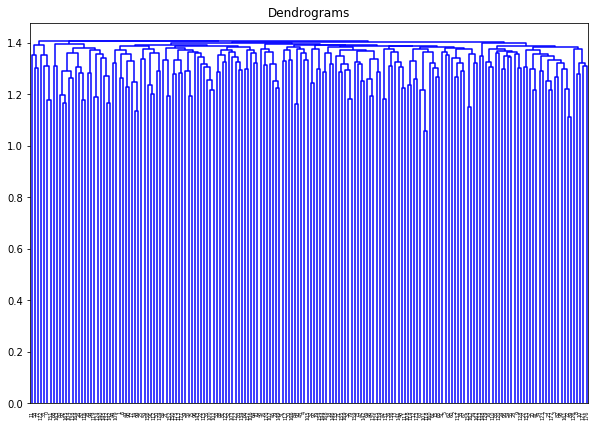

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
sch.dendrogram(sch.linkage(matd_tfidf, method='complete'))

**Notes on the Pubmed articles**

These were downloaded with the following script.

```python
from Bio import Entrez, Medline
Entrez.email = "YOUR EMAIL HERE"
import cPickle

try:
    docs = cPickle.load(open('pubmed.pic'))
except Exception, e:
    print e

    docs = {}
    for term in ['plasmodium', 'diabetes', 'asthma', 'cytometry']:
        handle = Entrez.esearch(db="pubmed", term=term, retmax=50)
        result = Entrez.read(handle)
        handle.close()
        idlist = result["IdList"]
        handle2 = Entrez.efetch(db="pubmed", id=idlist, rettype="medline", retmode="text")
        result2 = Medline.parse(handle2)
        for record in result2:
            title = record.get("TI", None)
            abstract = record.get("AB", None)
            if title is None or abstract is None:
                continue
            docs[title] = '\n'.join([title, abstract])
            print title
        handle2.close()
    cPickle.dump(docs, open('pubmed.pic', 'w'))
docs.values()
```